### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("processed_train.csv")

In [3]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предудыщей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [4]:
### Your code is here
data.HasDetections.value_counts()


0    99940
1    20012
Name: HasDetections, dtype: int64

Произведем процедуру отложенной выборки

In [25]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [26]:
### Your code is here


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

param_grid ={
    'LR__C': 0.01
}

pipe = Pipeline([('scaler', StandardScaler()),
                 ('LR', LogisticRegression(penalty='l2', C=0.01))])


custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]


cv_result_pipe = cross_validate(pipe, X, y, scoring='accuracy',
                                cv=custom_cv, return_train_score=True)


print(f"Accuracy на трейне: {np.mean(cv_result_pipe['train_score']).round(3)}")
print(f"Accuracy на тесте: {np.mean(cv_result_pipe['test_score']).round(3)}")

Accuracy на трейне: 0.841
Accuracy на тесте: 0.842


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам.

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [28]:
pipe.fit(X_train, y_train)
pred_test = pipe.predict(X_test)

### Your code is here
conf_matrix = pd.DataFrame(y_test.values, columns=['y_true'])
conf_matrix['y_predict'] = pd.DataFrame(pred_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [50]:
confusion_matrix = pd.crosstab(conf_matrix['y_true'], conf_matrix['y_predict'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted      0    1
Actual               
0          24726  293
1           4442  527


In [52]:
from sklearn.metrics import confusion_matrix

### Your code is here



tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()

print(f'True Negative errors: {tn}')
print(f'False Positive errors: {fp}')
print(f'False Negative errors: {fn}')
print(f'True Positive errors: {tp}')




True Negative errors: 24726
False Positive errors: 293
False Negative errors: 4442
True Positive errors: 527


**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [54]:
### Your code is here

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = (tp+tn)/ (tn + fp + fn + tp)
print(f'Accuracy равно: {accuracy_score(y_test, pred_test):.3f}' )
print(f'Accuracy_ равно: {accuracy:.3f}' )

Accuracy равно: 0.842
Accuracy_ равно: 0.842


Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [62]:
from sklearn.metrics import recall_score, precision_score

### Your code is here
precision = (tp) / (tp+fp)

recall = (tp) / (tp+fn)

print(round(precision,3))
print(round(recall, 3))

print(recall_score(y_test, pred_test))

print(precision_score(y_test, pred_test))

0.643
0.106
0.10605755685248541
0.6426829268292683


Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [68]:
### Your code is here

pred_probs = pipe.predict_proba(X_test)
pred_probs




array([[0.86206445, 0.13793555],
       [0.91020978, 0.08979022],
       [0.81369255, 0.18630745],
       ...,
       [0.87406249, 0.12593751],
       [0.94745209, 0.05254791],
       [0.77392705, 0.22607295]])

**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [69]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.6003717472118959
Recall: 	 0.1300060374320789
Threshold:	 0.4576697044825744


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [72]:
### Your code is here

precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])
ind = np.where(precision == precision[recall > 0.2].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")




Precison:	 0.4923229321446261
Recall: 	 0.2000402495471926
Threshold:	 0.33074936212516065


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [76]:
%matplotlib inline
def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)
    
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma');

Precision:	 0.16995681677976557
Recall: 	 0.9979875226403703
Threshold:	 0.021987348086574366


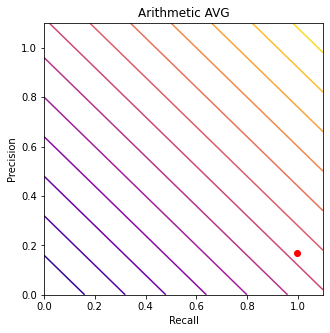

In [77]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y)/2

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro')

Precision:	 0.22336008856905618
Recall: 	 0.8120346146105857
Threshold:	 0.12529268151850823


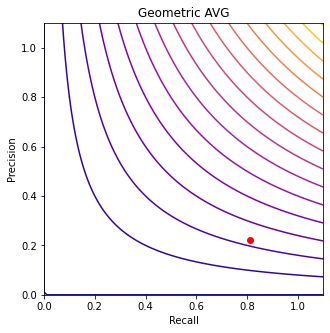

In [87]:
### Повторите для среднего геометрического
### Your code is here
metric_func = lambda x, y: (x * y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

level_lines(metric_func, "Geometric AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro')







Precision:	 0.35882471322197623
Recall: 	 0.35882471322197623
Threshold:	 0.23674927111110383


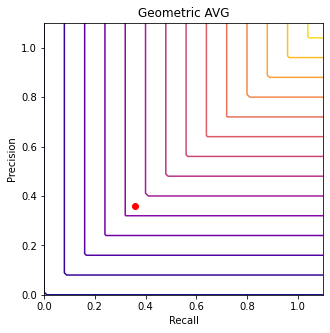

In [105]:
### Повторите для минимума
### Your code is here


metric_func = lambda x, y: np.minimum(x, y)

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

level_lines(metric_func, "Geometric AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro')



**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с подобранным параметром $\beta^2$ так, чтобы recall > 0.8.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

Precision:	 0.2849339014530755
Recall: 	 0.5248540953914268
Threshold:	 0.19234955640582005
F-мера: 	 0.3693527828919416
20700
0.014, 0.285, 0.525, 0.369


<ipython-input-178-5a2646b54519>:6: RuntimeWarning: invalid value encountered in true_divide
  metric_func = lambda x, y: ((1 + beta**2) * x * y) / (beta**2 * x + y)


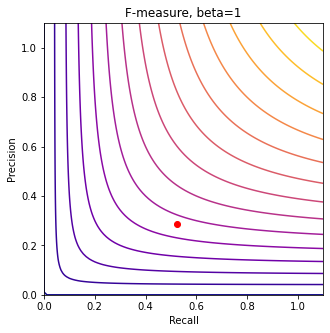

In [178]:
### Повторите для F-меры при beta=1
### Выведите ее вместе с precision/recall/threshold
# Задаем параметр beta
beta = 1
# Задаем функцию F-меры, которую надо максимизировать
metric_func = lambda x, y: ((1 + beta**2) * x * y) / (beta**2 * x + y)
# Сохраняем индекс, соответствующий максимальному значению F-меры
idx = (metric_func(precision, recall)).argmax()
# Рассчитываем F-меру при значениях precision и recall, соответствующих индексы при максимльном значении F-меры (рассчитываем максимальную F-меру)
F_measure = ((1 + beta**2) * precision[idx] * recall[idx]) / (beta**2 * precision[idx] + recall[idx])
print(f"Precision:\t {precision[idx]}")
print(f"Recall: \t {recall[idx]}")
print(f"Threshold:\t {thres[idx]}")
print(f"F-мера: \t {F_measure}")
print(idx)
print(f'{np.round(thres[arithm_idx], 3)}, {np.round(precision[idx], 3)}, {np.round(recall[idx], 3)}, {np.round(F_measure, 3)}')
level_lines(metric_func, "F-measure, beta=1")
plt.plot(recall[idx], precision[idx], 'ro');

In [167]:
### Повторите для F-меры при \beta=1
### Выведете ее вместе с precision/recall/threshold
### Your code is here
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, pred_probs[:, 1])

b = 1

f_scores = ((1 + b**2) * precision * recall) / ((b**2)*precision + recall)


print("Threshold for Best F-score: ", thresholds[np.argmax(f_scores)].round(3))
print("Precision for Best F-score: ", precision[np.argmax(f_scores)].round(3))
print("Recall for Best F-score: ", recall[np.argmax(f_scores)].round(3))
print("Best F-score: ", np.max(f_scores).round(3))

Threshold for Best F-score:  0.192
Precision for Best F-score:  0.285
Recall for Best F-score:  0.525
Best F-score:  0.369


In [182]:
### Повторите для F-меры при \beta=0.05
### Выведете ее вместе с precision/recall/threshold
### Your code is here
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, pred_probs[:, 1])

beta = 0.05
x = precision
y = recall

f_scores1 = ((1 + beta) * x * y) / (beta * x + y)


print("Threshold for Best F-score: ", thresholds[np.argmax(f_scores1)].round(3))
print("Precision for Best F-score: ", precision[np.argmax(f_scores1)].round(3))
print("Recall for Best F-score: ", recall[np.argmax(f_scores1)].round(3))
print("Best F-score: ", np.max(f_scores1).round(3))

Threshold for Best F-score:  0.497
Precision for Best F-score:  0.642
Recall for Best F-score:  0.109
Best F-score:  0.521


In [184]:
### Повторите для F-меры при \beta=0.05
### Выведете ее вместе с precision/recall/threshold
### Your code is here
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, pred_probs[:, 1])

beta = 4
x = precision
y = recall

f_scores1 = ((1 + beta) * x * y) / (beta * x + y)


print("Threshold for Best F-score: ", thresholds[np.argmax(f_scores1)].round(3))
print("Precision for Best F-score: ", precision[np.argmax(f_scores1)].round(3))
print("Recall for Best F-score: ", recall[np.argmax(f_scores1)].round(3))
print("Best F-score: ", np.max(f_scores1).round(3))

Threshold for Best F-score:  0.108
Precision for Best F-score:  0.21
Recall for Best F-score:  0.863
Best F-score:  0.532


In [135]:
(metric_func(precision, recall)).argmax()

314

In [137]:
### Повторите для F-меры при \beta=4
### Выведете ее вместе с precision/recall/threshold
### Your code is here

### Повторите для F-меры при beta=1
### Выведите ее вместе с precision/recall/threshold
# Задаем параметр beta
beta = 0.05
# Задаем функцию F-меры, которую надо максимизировать
metric_func = lambda x, y: ((1 + beta**2) * x * y) / (beta**2 * x + y)
# Сохраняем индекс, соответствующий максимальному значению F-меры
idx = (metric_func(precision, recall)).argmax()
# Рассчитываем F-меру при значениях precision и recall, соответствующих индексы при максимльном значении F-меры (рассчитываем максимальную F-меру)
F_measure = ((1 + beta**2) * precision[idx] * recall[idx]) / (beta**2 * precision[idx] + recall[idx])
print(f"Precision:\t {precision[idx]}")
print(f"Recall: \t {recall[idx]}")
print(f"Threshold:\t {thres[idx]}")
print(f"F-мера: \t {F_measure}")
print(idx)
print(f'{np.round(thres[arithm_idx], 3)}, {np.round(precision[idx], 3)}, {np.round(recall[idx], 3)}, {np.round(F_measure, 3)}')
level_lines(metric_func, "F-measure, beta=1")
plt.plot(recall[idx], precision[idx], 'ro');


TypeError: 'function' object is not subscriptable